In [1]:
%matplotlib inline

from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append(os.path.join(os.getcwd(), os.pardir, 'src'))

%load_ext autoreload

%autoreload 2
from visualization.visualize import *

# Load WHO Data

In [3]:
who_df = pd.read_csv(Path("../data/interim/calc_cols_added.csv"), index_col=0)
who_df.head(2)

,Iso Code,Country Name,WHO Region,Year,Vaccine Type,Admin1,Admin2,DenomType,Denominator,Numerator,Coverage,recalc_numerator,available_admin,normalized_country,indicator,group,vaccine,timing,reported
0,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aab Band,1.0,1266.0,NaN,51.801245,655.803767,Aab Band,afghanistan,1,BCG,BCG,1st_birth,True
1,AFG,Afghanistan,EMRO,2016,BCG,NaN,Aab Kamari,1.0,4599.0,NaN,94.674670,4354.088093,Aab Kamari,afghanistan,1,BCG,BCG,1st_birth,True


In [4]:
# These countries appear in both the MICS and the WHO datasets
overlaps = [
    'Benin',
    'Cameroon',
    'Cuba',
    'Dominican Republic',
    'El Salvador',
    'Guyana',
    'Kazakhstan',
    'Kyrgyzstan',
    'Malawi',
    'Mali',
    'Mexico',
    'Nepal',
    'Paraguay',
    'Sudan',
    'Swaziland',
    'Turkmenistan',
    'Zimbabwe',
]

# some MICS regions are just subsets of a country, so we
# can only analyze the ones that appear in both datasets
partial_matches = {
    'Kenya (Bungoma County)': 'Kenya',
    'Kenya (Kakamega County)': 'Kenya',
    'Kenya (Turkana County)': 'Kenya',
    'Pakistan (Punjab)': 'Pakistan',
    'Pakistan (Sindh)': 'Pakistan',
}

# Some MICS countries have their names written differently
# Thus maps the MICS version as the key to the WHO version
# as the value
overlap_map = {
    'Guinea Bissau': 'Guinea-Bissau',
    'Sao Tome and Principe': 'Sao Tome & Principe',
}

all_mics_overlaps = list(overlap_map.keys()) + list(partial_matches.keys()) + overlaps

# Load MICS Survey data

In [5]:
childrens_surveys = dict()

for f in Path("../data/interim/MICS").iterdir():
    if f.name.startswith('.'):
        continue
    elif not f.is_dir():
        continue
    childrens_surveys[f.stem] = pd.read_csv(f/'ch.csv', index_col=0)

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (14,21,30,32,35,37,45,57,77,79,82,98,101,103,104,106,145,149,153,174,175,176,177,178,180,181,182,183,184,185,186,187,188,189,199,200,201,203,204,205,206,208,219,220,221,222,223,224,225,226,227,228,230,231,232,238,239,240,241,246,249,266,267,268,270,281,291,300) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (245,253,254,255,265,289,345) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (15,16,17,18,78,81,

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (15,16,17,18,78,81,145,152,174,177,179,181,185,187,203,205,206,207,219,226,230,232,286,314,316) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,25,103,104,105,106,107,108,176,178,183,197,198,199,202,213,214,217,229,231,233,235,240,251,253,279) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (15,16,17,18,19,101,102,103,170,181,193,200,264,290) have mixed types. Specify dtype option on import or set lo

### Upsample surveys based on child weights to get representative child counts

In [6]:
childrens_surveys_upsampled = dict()
for country, df in childrens_surveys.items():
    rng = np.random.RandomState(12345)
    
    w_col = 'chweight' if 'chweight' in df.columns else 'CHWEIGHT'
    
    smpl = rng.choice(df.index, 100000, p=df[w_col] / df[w_col].sum())
    childrens_surveys_upsampled[country] = df.loc[smpl, :]

In [7]:
relevant_vars = [
    # When conducted
    'UF8Y',
    
    # Where conducted (urban/rural)
    'HH6',
    'HH7',
    
    # Child Age
    'AG2',
    'CAGE',
    'AG1Y',
]

In [8]:
subsetted_dfs = []
for c in all_mics_overlaps:
    df = childrens_surveys_upsampled[c]
    im_vars = [c for c in df.columns if c.startswith('IM')]
    
    df['country'] = c
    subsetted_dfs.append(df[['country'] + im_vars + relevant_vars].copy())

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
all_mics_children_data = pd.concat(subsetted_dfs)

In [10]:
subsetted_dfs = []
for c in all_mics_overlaps:
    df = childrens_surveys[c]
    im_vars = [c for c in df.columns if c.startswith('IM')]
    
    df['country'] = c
    subsetted_dfs.append(df[['country'] + im_vars + relevant_vars].copy())

raw_mics_children_data = pd.concat(subsetted_dfs)

In [11]:
# nepal is in nepalese years...
all_mics_children_data.replace({'UF8Y': {2070.: 2013., 2071.: 2014.}}, inplace=True)
raw_mics_children_data.replace({'UF8Y': {2070.: 2013., 2071.: 2014.}}, inplace=True)

In [12]:
# just include surveys done in at least 2014
min_year = all_mics_children_data.groupby('country').UF8Y.min()
to_include = min_year[min_year >= 2014].index.tolist()

mics_children_data_who_countries = all_mics_children_data[all_mics_children_data.country.isin(to_include)]
raw_mics_children_data_who_countries = raw_mics_children_data[raw_mics_children_data.country.isin(to_include)]

print(mics_children_data_who_countries.shape)
mics_children_data_who_countries.dropna(how='all', axis=1, inplace=True)
raw_mics_children_data_who_countries = raw_mics_children_data_who_countries[mics_children_data_who_countries.columns]
print(mics_children_data_who_countries.shape)

(1900000, 359)


/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


(1900000, 356)


In [13]:
country_year_map = mics_children_data_who_countries.groupby('country').UF8Y.max().to_dict()

mics_children_data_who_countries['survey_year'] = mics_children_data_who_countries.country.replace(country_year_map)
raw_mics_children_data_who_countries['survey_year'] = \
    raw_mics_children_data_who_countries.country.replace(country_year_map)

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
from collections import namedtuple

Vax = namedtuple('Vax',
                 ['name',           # Group name
                  'doses_dict',     # map standard WHO dose names to year columns
                  'ever_col',       # yes/no for vax ever given 
                  'ever_col_year']) # year for vax ever given

vaxes = [
    Vax(name='BCG',
        doses_dict={'BCG': ['IM3BY']},
        ever_col=['IM7'],
        ever_col_year=[]),
    
    # DTP or Penta
    Vax(name='DTP',
        doses_dict={'DTP1': ['IM3D1Y', 'IM3PV1Y'],
                    'DTP2': ['IM3D2Y', 'IM3PV2Y'],
                    'DTP3': ['IM3D3Y', 'IM3PV3Y'],
                    'DTP4': ['IM3D4Y', 'IM3PV4Y']},
        ever_col=['IM17', 'IM17A', 'IM11', 'IM10A', 'IM11A'],
        ever_col_year=[]),
    
    Vax(name='Measles',
        doses_dict={'MCV1': ['IM3M1Y'],
                    'MCV2': ['IM3M2Y']},
        ever_col=['IM16'],
        ever_col_year=['IM3MY']),
    
# polio
# flu/Hib
# hepb
# pneumo / PCV
]

In [15]:
# Harmonize "ever" questions:
ever_harmonize_map = {
    # yes
    'First two weeks': 1.0,
    'First eight weeks': 1.0,
    'Dans les 2 premières semaines': 1.0,
    'Later': 1.0,
    'Plus tard': 1.0,
    'Sim': 1.0,
    'Si': 1.0,
    'Sí': 1.0,
    'Oui': 1.0,
    'Yes': 1.0,
    '1.0': 1.0,
    '2.0': 1.0,
    '3.0': 1.0,
    '4.0': 1.0,
    '5.0': 1.0,
    '6.0': 1.0,
     2.0: 1.0,
     3.0: 1.0,
     4.0: 1.0,
     '2009.0': 1.0,
     '2010.0': 1.0,
     '2011.0': 1.0,
     '2012.0': 1.0,
     '2013.0': 1.0,
     '2014.0': 1.0,
     '2015.0': 1.0,
     '2016.0': 1.0,
     2013.0: 1.0,
     2014.0: 1.0,
     2015.0: 1.0,
     2016.0: 1.0,  
    'Dans carte de vaccination': 1.0,
    'Déclaration de la mère': 1.0,
    'Madre reportada': 1.0,
    'Reporte de la madre': 1.0,
    'Réponse de la mère': 1.0,
    'Marcada en la tarjeta': 1.0,
    'Marcada sobre la tarjeta': 1.0,
    'Marked on card': 1.0,
    'Marqué sur le carnet': 1.0,
    'Mother reported': 1.0,
    
    # no
    'Non': 0.0,
    'NÃ£o': 0.0,
    'No': 0.0,
    'No aplicada': 0.0,
    'No vacunado': 0.0,
    'Pas reçue/pas vue dans le carnet': 0.0,
    
    # don't know
    'DK': np.nan,
    'Manquant': np.nan,
    'Non déclaré/Pas de réponse': np.nan,
    'Ne sait pas': np.nan,
    'Missing': np.nan,
    'Em falta': np.nan,
    'Incohérent': np.nan,
    'Inconsistent': np.nan,
    'Inconsistente': np.nan,
    'NS': np.nan,
    'NSP': np.nan,
    'No dada': np.nan,
    'No sabe': np.nan,
    'Not given': np.nan,
    'NÃ£o Sabe': np.nan,
    'Omitido': np.nan,
    'Pas donné': np.nan,
}

In [16]:
vaxed_data = mics_children_data_who_countries.copy()
raw_vaxed_data = raw_mics_children_data_who_countries.copy()

## All one year olds

In [36]:
MIN_AGE = 12
MAX_AGE = 24

# calc denominator
vaxed_data[f"denom"] = (vaxed_data.CAGE >= MIN_AGE) & (vaxed_data.CAGE <= MAX_AGE)
raw_vaxed_data[f"denom"] = (raw_vaxed_data.CAGE >= MIN_AGE) & (raw_vaxed_data.CAGE <= MAX_AGE)

vaxed_data = vaxed_data[vaxed_data.denom]
raw_vaxed_data = raw_vaxed_data[raw_vaxed_data.denom]

In [37]:
vaxed_data

,AG1Y,AG2,CAGE,HH6,HH7,IM1,IM10,IM10A,IM10B,IM11,IM11A,IM11B,IM11C,IM11D,IM11E,IM11F,IM12,IM12A,IM12B,IM12C,IM12D,IM12E,IM13,IM13A,IM13B,IM13C,IM13D,IM14,IM14A,IM15,IM15A,IM15B,IM15C,IM15D,IM15E,IM15F,IM15G,IM15H,IM15I,IM15J,IM16,IM16A,IM16B,IM16C,IM17,IM17A,IM17B,IM17C,IM17D,IM17E,...,IM3SB2M,IM3SB2Y,IM3SB3D,IM3SB3M,IM3SB3Y,IM3T1D,IM3T1M,IM3T1Y,IM3T2D,IM3T2M,IM3T2Y,IM3T3D,IM3T3M,IM3T3Y,IM3V1D,IM3V1M,IM3V1Y,IM3V2D,IM3V2M,IM3V2Y,IM3V3D,IM3V3M,IM3V3Y,IM3VD,IM3VM,IM3VY,IM3YD,IM3YM,IM3YY,IM5,IM6,IM7,IM7A,IM7B,IM8,IM9,UF8Y,country,survey_year,denom,mics_BCG,mics_BCG_any_dose,mics_DTP1,mics_DTP2,mics_DTP3,mics_DTP4,mics_DTP_any_dose,mics_MCV1,mics_MCV2,mics_Measles_any_dose
2314,2012,1,16.0,Rural,Oio,Sim vi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Marked on card,Marked on card,Marked on card,Marked on card,Marked on card,Marked on card,NaN,NaN,NaN,NaN,NaN,NaN,20.0,9.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014.0,Guinea Bissau,2014.0,True,True,True,False,False,False,False,False,False,False,True
7580,2012,1,19.0,Urbano,SAB,Sim vi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mother reported,Mother reported,Mother reported,Mother reported,Mother reported,Mother reported,NaN,NaN,NaN,NaN,NaN,NaN,16.0,8.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014.0,Guinea Bissau,2014.0,True,True,True,False,False,False,False,False,False,False,True
114,2013.0,1,15.0,Rural,Tombali,Não,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,NaN,NaN,No,NaN,2014.0,Guinea Bissau,2014.0,True,False,True,False,False,False,False,True,False,False,False
6228,2012,1,21.0,Rural,Gabú,Não,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,2014.0,Guinea Bissau,2014.0,True,False,False,False,False,False,False,False,False,False,False
7266,2012,1,19.0,Urbano,SAB,Sim vi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Marked on card,Marked on card,Marked on card,Marked on card,Marked on card,Marked on card,NaN,NaN,NaN,NaN,NaN,NaN,28.0,6.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014.0,Guinea Bissau,2014.0,True,True,True,False,False,False,False,False,False,False,True
3122,2013,1,16.0,Urbano,Biombo,Sim vi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not given,Not given,Not given,Not given,Not given,Not given,NaN,NaN,NaN,NaN,NaN,NaN,29.0,10.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014.0,Guinea Bissau,2014.0,True,True,True,False,False,False,False,False,False,False,True
7663,2013,0,12.0,Urbano,SAB,Sim vi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mother reported,Mother reported,Mother reported,Mother reported,Mother reported,Mother reported,NaN,NaN

In [38]:
all_cols_added = ["denom"]

def get_ever_based_on_any_dose(dd, ever, ever_yr, ca):
    return (((dd[ca] == 1.0).any(axis=1) |    # any dose that we added
             (dd[ever_yr].replace(ever_harmonize_map) == 1).any(axis=1) | # any dose marked with year
             (dd[ever].replace(ever_harmonize_map) == 1).any(axis=1)) & # any dose recall
             dd[f"denom"])
    
#     return (((vaxed_data[cols_added] == 1.0).any(axis=1) |    # any
#               pd.notnull(vaxed_data[v.ever_col_year]).any(axis=1) | 
#               (vaxed_data[v.ever_col].replace(ever_harmonize_map) == 1.0).any(axis=1)) &
#              vaxed_data[f"denom"])

for v in vaxes:

    cols_added = []

    print(v.name)

    # track individual doses
    for dose_name, dose_cols in v.doses_dict.items():

        print(dose_name)
        new_col = f"mics_{dose_name}"
        vaxed_data[new_col] = pd.notnull(vaxed_data[dose_cols]).any(axis=1) & vaxed_data[f"denom"]
        raw_vaxed_data[new_col] = pd.notnull(raw_vaxed_data[dose_cols]).any(axis=1) & raw_vaxed_data[f"denom"]

        cols_added.append(new_col)

    # track ever based on ever_col or individual doses
    new_col = f"mics_{v.name}_any_dose"    
    vaxed_data[new_col] = get_ever_based_on_any_dose(vaxed_data, v.ever_col, v.ever_col_year, cols_added)    
    raw_vaxed_data[new_col] = get_ever_based_on_any_dose(raw_vaxed_data, v.ever_col, v.ever_col_year, cols_added)

    all_cols_added += cols_added + [new_col]

BCG
BCG


/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


DTP
DTP1
DTP2
DTP3
DTP4
Measles
MCV1
MCV2


#### Deprecated per-year calculations (too few children)

In [39]:
# all_cols_added = dict()

# for ix, yr in enumerate(list(range(2016, 2013, -1))):
    
#     all_cols_added[yr] = [f"denom_{yr}"]
    
#     # calc denominator
#     vaxed_data[f"denom_{yr}"] = vaxed_data.AG1Y == yr
#     raw_vaxed_data[f"denom_{yr}"] = raw_vaxed_data.AG1Y == yr

#     for v in vaxes:
        
#         cols_added = []
        
#         print(v.name)
        
#         # track individual doses
#         for dose_name, dose_cols in v.doses_dict.items():
#             print(dose_name)
            
#             new_col = f"{dose_name}_{yr}"
#             vaxed_data[new_col] = (vaxed_data[dose_cols] == yr).any(axis=1) & vaxed_data[f"denom_{yr}"]
#             raw_vaxed_data[new_col] = (raw_vaxed_data[dose_cols] == yr).any(axis=1) & raw_vaxed_data[f"denom_{yr}"]
            
#             cols_added.append(new_col)
        
#         # track ever based on ever_col or individual doses
#         new_col = f"{v.name}_any_dose_{yr}"
        
#         vaxed_data[new_col] = (((vaxed_data[cols_added] == 1.0).any(axis=1) | 
#                                 (vaxed_data[v.ever_col_year] == yr).any(axis=1) | 
#                                 (vaxed_data[v.ever_col].replace(ever_harmonize_map) == 1.0).any(axis=1)) &
#                                vaxed_data[f"denom_{yr}"])
        
#         raw_vaxed_data[new_col] = (((raw_vaxed_data[cols_added] == 1.0).any(axis=1) | 
#                         (raw_vaxed_data[v.ever_col_year] == yr).any(axis=1) | 
#                         (raw_vaxed_data[v.ever_col].replace(ever_harmonize_map) == 1.0).any(axis=1)) &
#                        raw_vaxed_data[f"denom_{yr}"])

#         all_cols_added[yr] += cols_added + [new_col]

In [40]:
sampled_data = vaxed_data.groupby(['country', 'HH7'])[all_cols_added].sum()
raw_data = raw_vaxed_data.groupby(['country', 'HH7'])[all_cols_added].sum()

# calculate coverage
original_denom = sampled_data[f"denom"].copy()
cov_percentages = sampled_data.divide(original_denom, axis=0)
cov_percentages.denom = original_denom

# only show data where we talked to enough kids
mics_to_compare = cov_percentages.loc[raw_data[f"denom"] >= 20, :].reset_index()

print(mics_to_compare.shape)
mics_to_compare.head(2)

(215, 13)


,country,HH7,denom,mics_BCG,mics_BCG_any_dose,mics_DTP1,mics_DTP2,mics_DTP3,mics_DTP4,mics_DTP_any_dose,mics_MCV1,mics_MCV2,mics_Measles_any_dose
0,Benin,Alibori,1555.0,0.554341,0.819936,0.0,0.0,0.0,0.0,0.252090,0.0,0.0,0.660450
1,Benin,Atacora,1902.0,0.722923,0.923239,0.0,0.0,0.0,0.0,0.197687,0.0,0.0,0.772345


In [41]:
### Create immunization value counts

In [42]:
who = pd.read_csv(Path("../data/interim/who_subnational_with_geocodes.csv"), index_col=0)


# for v in ['DTP']:
#     who[f"who_any_{v}"] = who[[c for c in who.columns if c.startswith(v)]].max(axis=1)

coverage_by_Admin1 = (who.groupby(['Country Name', 'google_admin_1', 'Vaccine Type'])
                                 [['recalc_numerator', 'Denominator']]
                                    .sum()
                                    .pipe(lambda x: x.recalc_numerator / x.Denominator)
                                    .unstack())

coverage_by_Admin1.reset_index(inplace=True)
coverage_by_Admin1.describe()

Vaccine Type,BCG,DTP1,DTP2,DTP3,DTP4,HepB1,HepB2,HepB3,HepB_BD,HepB_BDall,Hib1,Hib2,Hib3,IPV1,MCV1,MCV2,OPV0,PAB_DTP1,PCV1,PCV2,PCV3,Pol1,Pol2,Pol3,RCV1,RCV2,Rota1,RotaC,TT2plus,VAD1,Varicella,YFV
count,1095.000000,1678.000000,23.000000,1683.000000,513.000000,173.000000,23.000000,1098.000000,1031.000000,503.000000,23.000000,23.000000,674.000000,651.000000,1683.000000,1103.000000,8.000000,502.000000,560.000000,560.000000,560.000000,7.000000,7.000000,1100.000000,667.000000,165.000000,503.000000,503.000000,193.000000,513.000000,15.000000,502.000000
mean,0.874055,0.860185,0.949113,0.918775,0.085269,0.410407,0.949113,0.799589,0.326796,0.250409,0.978399,0.949113,0.840542,0.524631,inf,0.583508,0.623630,0.166537,0.803170,0.754480,0.660757,0.972545,0.866326,0.915945,0.216762,0.280153,0.574655,0.517658,0.611779,0.288741,1.010840,0.402558
std,0.311004,0.487516,0.110009,0.295715,0.271002,0.473688,0.110009,0.338935,0.441640,0.413542,0.075609,0.110009,0.304393,0.390831,NaN,0.420305,0.258216,0.347518,0.394896,0.367815,0.424258,0.147825,0.168178,0.282087,0.407714,0.458075,0.497728,0.454253,0.384563,0.371789,0.019307,0.428957
min,0.000000,0.000000,0.587594,0.000000,0.000000,0.000000,0.587594,0.000000,0.000000,0.000000,0.750234,0.587594,0.000000,0.000000,0.000000,0.000000,0.310356,0.000000,0.000000,0.000000,0.000000,0.756239,0.595722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.998671,0.000000
25%,0.820000,0.820000,0.961725,0.840221,0.000000,0.000000,0.961725,0.755489,0.000000,0.000000,0.981310,0.961725,0.771534,0.000000,0.831943,0.000000,0.400679,0.000000,0.739558,0.682397,0.105000,0.893104,0.796381,0.847458,0.000000,0.000000,0.000000,0.000000,0.424322,0.000000,1.000000,0.000000
50%,0.952900,0.950319,0.992741,0.933541,0.000000,0.017987,0.992741,0.924643,0.000000,0.000000,1.000000,0.992741,0.913972,0.620000,0.933145,0.742432,0.613867,0.000000,0.900392,0.882832,0.820000,0.943099,0.831953,0.929943,0.000000,0.000000,0.760000,0.690000,0.636106,0.020000,1.000000,0.404500
75%,0.990000,1.000000,1.000000,0.981000,0.000000,0.950610,1.000000,0.973925,0.889733,0.500249,1.000000,1.000000,0.986214,0.861813,0.983668,0.963737,0.879335,0.000000,1.016442,0.965299,0.949556,1.081097,0.958972,0.976646,0.000000,0.830000,0.945753,0.862464,0.832551,0.589869,1.014342,0.799985
max,4.819480,14.770888,1.125898,10.706266,1.472000,1.371795,1.125898,3.287648,1.699566,1.699566,1.160075,1.125898,3.287648,1.673000,inf,1.868551,0.921240,2.570000,2.750000,1.990000,1.980000,1.160075,1.125898,7.451214,1.752156,1.436176,3.640000,3.570457,2.570000,1.870000,1.049161,2.586290


## Geocode from `geocodes.json`

In [43]:
import json
with open(Path("../data/interim/MICS/geocodes.json"), 'r') as f:
    lookups = json.load(f)

In [44]:
def extract_canonical_location_info(item):
    place_id, google_admin_1, google_admin_2 = None, None, None
    
    if item['results']:
        place_id = item['results'][0]['place_id']
        
        for ac in item['results'][0]['address_components']:
            if 'administrative_area_level_1' in ac['types']:
                google_admin_1 = unidecode(ac['long_name'])
            elif 'administrative_area_level_2' in ac['types']:
                google_admin_2 = unidecode(ac['long_name'])
    
    return {'google_admin_1': google_admin_1,
            'google_admin_2': google_admin_2,
            'place_id': place_id}


In [45]:
from unidecode import unidecode

In [46]:
reses = []
for ix, item in mics_to_compare.iterrows():
    
    reses.append(extract_canonical_location_info(lookups[item.country][item.HH7]))


mics_to_compare['google_admin_1'] = pd.DataFrame(reses).google_admin_1
mics_to_compare.head()

,country,HH7,denom,mics_BCG,mics_BCG_any_dose,mics_DTP1,mics_DTP2,mics_DTP3,mics_DTP4,mics_DTP_any_dose,mics_MCV1,mics_MCV2,mics_Measles_any_dose,google_admin_1
0,Benin,Alibori,1555.0,0.554341,0.819936,0.0,0.0,0.0,0.0,0.252090,0.0,0.0,0.660450,Alibori
1,Benin,Atacora,1902.0,0.722923,0.923239,0.0,0.0,0.0,0.0,0.197687,0.0,0.0,0.772345,Atakora Department
2,Benin,Atlantique,3068.0,0.768905,0.972947,0.0,0.0,0.0,0.0,0.187093,0.0,0.0,0.673077,Atlantique Department
3,Benin,Borgou,2332.0,0.591767,0.762864,0.0,0.0,0.0,0.0,0.176244,0.0,0.0,0.561750,Borgou
4,Benin,Collines,1558.0,0.801669,0.937099,0.0,0.0,0.0,0.0,0.125160,0.0,0.0,0.799743,Collines Department


In [47]:
who_and_mics_by_admin1 = mics_to_compare.merge(coverage_by_Admin1,
                                               left_on=['country', 'google_admin_1'],
                                               right_on=['Country Name', 'google_admin_1'],
                                               how='inner')

print(who_and_mics_by_admin1.shape)

(81, 47)


In [48]:
who_and_mics_by_admin1.head()

,country,HH7,denom,mics_BCG,mics_BCG_any_dose,mics_DTP1,mics_DTP2,mics_DTP3,mics_DTP4,mics_DTP_any_dose,mics_MCV1,mics_MCV2,mics_Measles_any_dose,google_admin_1,Country Name,BCG,DTP1,DTP2,DTP3,DTP4,HepB1,HepB2,HepB3,HepB_BD,HepB_BDall,Hib1,Hib2,Hib3,IPV1,MCV1,MCV2,OPV0,PAB_DTP1,PCV1,PCV2,PCV3,Pol1,Pol2,Pol3,RCV1,RCV2,Rota1,RotaC,TT2plus,VAD1,Varicella,YFV
0,Benin,Alibori,1555.0,0.554341,0.819936,0.0,0.0,0.0,0.0,0.252090,0.0,0.0,0.660450,Alibori,Benin,1.016542,1.058486,NaN,1.047539,0.0,NaN,NaN,1.047539,0.0,0.0,NaN,NaN,1.047539,0.0,1.009117,0.0,NaN,0.0,1.058486,1.034763,1.047539,NaN,NaN,1.047539,0.0,NaN,0.0,0.0,NaN,0.0,NaN,1.009117
1,Benin,Atacora,1902.0,0.722923,0.923239,0.0,0.0,0.0,0.0,0.197687,0.0,0.0,0.772345,Atakora Department,Benin,1.033711,1.087449,NaN,1.031392,0.0,NaN,NaN,1.031392,0.0,0.0,NaN,NaN,1.031392,0.0,0.988252,0.0,NaN,0.0,1.078859,1.065248,1.022423,NaN,NaN,1.031392,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.989325
2,Benin,Atlantique,3068.0,0.768905,0.972947,0.0,0.0,0.0,0.0,0.187093,0.0,0.0,0.673077,Atlantique Department,Benin,1.073866,1.166577,NaN,1.108723,0.0,NaN,NaN,1.108723,0.0,0.0,NaN,NaN,1.108723,0.0,1.049901,0.0,NaN,0.0,1.166577,1.117320,1.108723,NaN,NaN,1.007380,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.964607
3,Benin,Borgou,2332.0,0.591767,0.762864,0.0,0.0,0.0,0.0,0.176244,0.0,0.0,0.561750,Borgou,Benin,1.082734,1.088582,NaN,1.059147,0.0,NaN,NaN,1.059147,0.0,0.0,NaN,NaN,1.059147,0.0,1.021724,0.0,NaN,0.0,1.088582,1.059193,1.059147,NaN,NaN,1.059147,0.0,NaN,0.0,0.0,NaN,0.0,NaN,1.021724
4,Benin,Collines,1558.0,0.801669,0.937099,0.0,0.0,0.0,0.0,0.125160,0.0,0.0,0.799743,Collines Department,Benin,0.937545,1.036790,NaN,1.000936,0.0,NaN,NaN,1.000936,0.0,0.0,NaN,NaN,1.000936,0.0,1.005235,0.0,NaN,0.0,1.036790,1.019388,1.000936,NaN,NaN,1.000936,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.923000


In [49]:
pd.set_option("display.max_columns", 100)
who_and_mics_by_admin1.describe()

,denom,mics_BCG,mics_BCG_any_dose,mics_DTP1,mics_DTP2,mics_DTP3,mics_DTP4,mics_DTP_any_dose,mics_MCV1,mics_MCV2,mics_Measles_any_dose,BCG,DTP1,DTP2,DTP3,DTP4,HepB1,HepB2,HepB3,HepB_BD,HepB_BDall,Hib1,Hib2,Hib3,IPV1,MCV1,MCV2,OPV0,PAB_DTP1,PCV1,PCV2,PCV3,Pol1,Pol2,Pol3,RCV1,RCV2,Rota1,RotaC,TT2plus,VAD1,Varicella,YFV
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.0,81.0,81.000000,54.000000,80.000000,0.0,80.000000,31.0,0.0,0.0,54.000000,54.000000,31.0,0.0,0.0,31.000000,31.000000,80.000000,54.000000,0.0,31.0,31.000000,31.000000,31.000000,0.0,0.0,54.000000,31.0,0.0,31.000000,31.000000,0.0,31.000000,0.0,31.000000
mean,2214.370370,0.534641,0.919028,0.241318,0.222030,0.217450,0.176530,0.582442,0.0,0.0,0.701638,0.948097,0.957022,NaN,0.892984,0.0,NaN,NaN,0.853689,0.409281,0.0,NaN,NaN,0.935212,0.423081,0.952150,0.417972,NaN,0.0,1.019705,0.962121,0.933099,NaN,NaN,0.885430,0.0,NaN,0.547544,0.478370,NaN,0.347452,NaN,0.868769
std,1654.713657,0.350994,0.113436,0.359859,0.364534,0.358280,0.336900,0.343999,0.0,0.0,0.149006,0.166828,0.276388,NaN,0.132139,0.0,NaN,NaN,0.215277,0.479766,0.0,NaN,NaN,0.135962,0.357624,0.126731,0.489876,NaN,0.0,0.161906,0.147691,0.138178,NaN,NaN,0.143398,0.0,NaN,0.456661,0.398472,NaN,0.317960,NaN,0.142217
min,151.000000,0.000000,0.406977,0.000000,0.000000,0.000000,0.000000,0.092988,0.0,0.0,0.320588,0.524631,0.000000,NaN,0.522000,0.0,NaN,NaN,0.000000,0.000000,0.0,NaN,NaN,0.602267,0.000000,0.564263,0.000000,NaN,0.0,0.620956,0.592924,0.601095,NaN,NaN,0.522000,0.0,NaN,0.000000,0.000000,NaN,0.000000,NaN,0.564263
25%,981.000000,0.100000,0.910615,0.000000,0.000000,0.000000,0.000000,0.242137,0.0,0.0,0.593640,0.926048,0.912503,NaN,0.817772,0.0,NaN,NaN,0.762750,0.000000,0.0,NaN,NaN,0.871953,0.000000,0.892695,0.000000,NaN,0.0,0.970925,0.900935,0.873573,NaN,NaN,0.804937,0.0,NaN,0.000000,0.000000,NaN,0.000000,NaN,0.809477
50%,1622.000000,0.697408,0.949815,0.011213,0.000000,0.000000,0.000000,0.729608,0.0,0.0,0.717562,0.963500,0.982209,NaN,0.919311,0.0,NaN,NaN,0.921567,0.000000,0.0,NaN,NaN,0.939022,0.593951,0.974500,0.000000,NaN,0.0,1.036790,0.965125,0.931074,NaN,NaN,0.909743,0.0,NaN,0.721368,0.699972,NaN,0.388062,NaN,0.860648
75%,2859.000000,0.807514,0.980711,0.440087,0.440087,0.440087,0.127383,0.919103,0.0,0.0,0.813115,0.990519,1.037626,NaN,0.982126,0.0,NaN,NaN,0.986139,0.957000,0.0,NaN,NaN,1.031321,0.706355,0.999603,0.979910,NaN,0.0,1.106423,1.070810,1.038877,NaN,NaN,0.984597,0.0,NaN,0.944067,0.814366,NaN,0.594686,NaN,0.977120
max,8776.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.958737,1.453766,2.561605,NaN,1.171748,0.0,NaN,NaN,1.171748,0.990000,0.0,NaN,NaN,1.171748,0.877436,1.306462,1.000000,NaN,0.0,1.406040,1.244168,1.171748,NaN,NaN,1.115194,0.0,NaN,1.193250,1.034951,NaN,0.975673,NaN,1.215758


In [50]:
# for v in ['DTP', 'MCV']:
#     cols = [c for c in who_and_mics_by_admin1.columns if c.startswith(v)]

# who_and_mics_by_admin1[cols].max(axis=1)

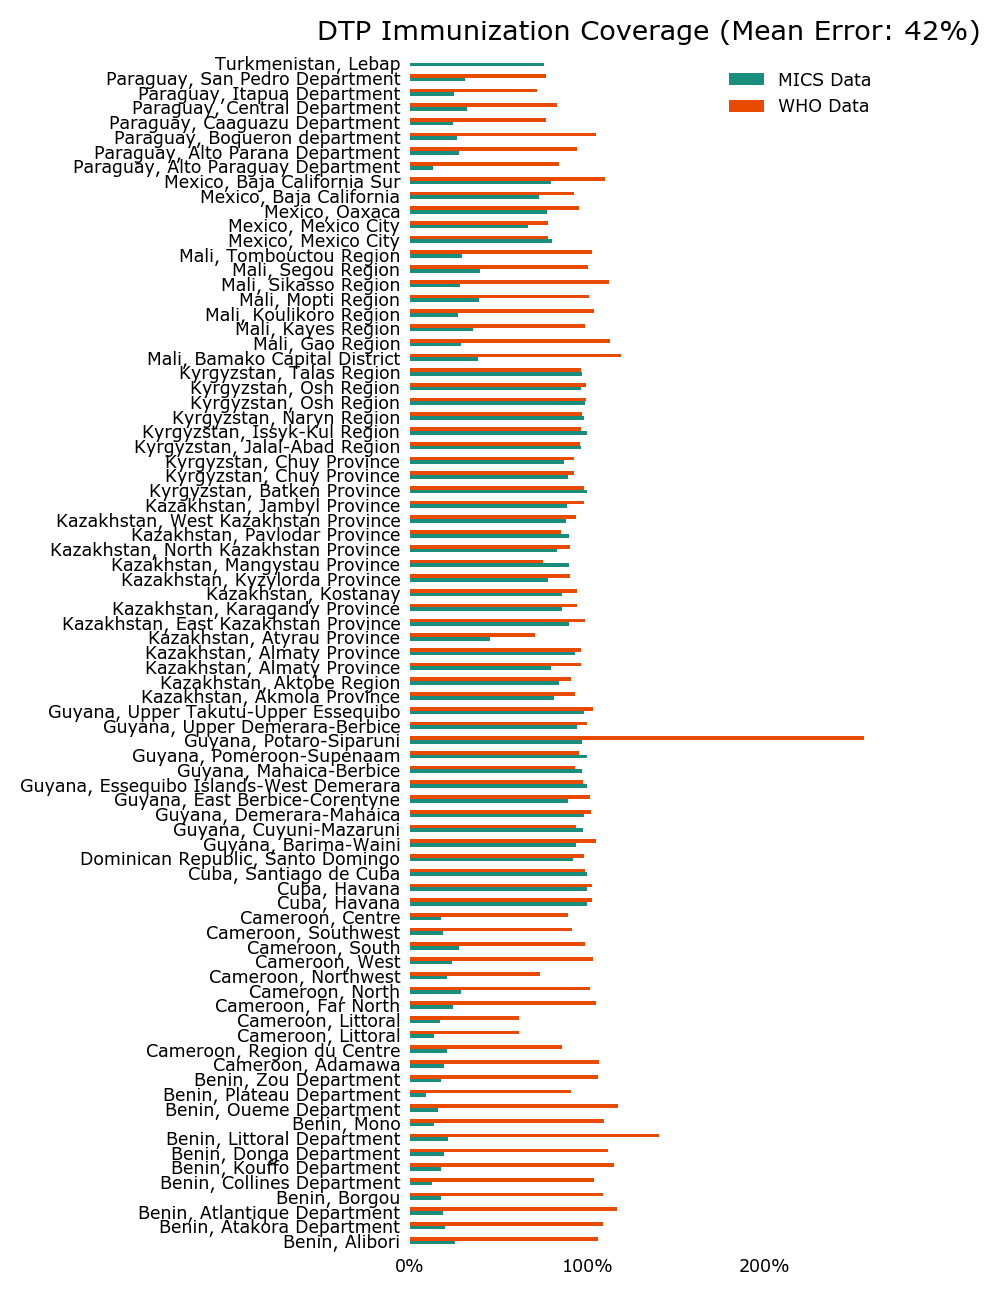

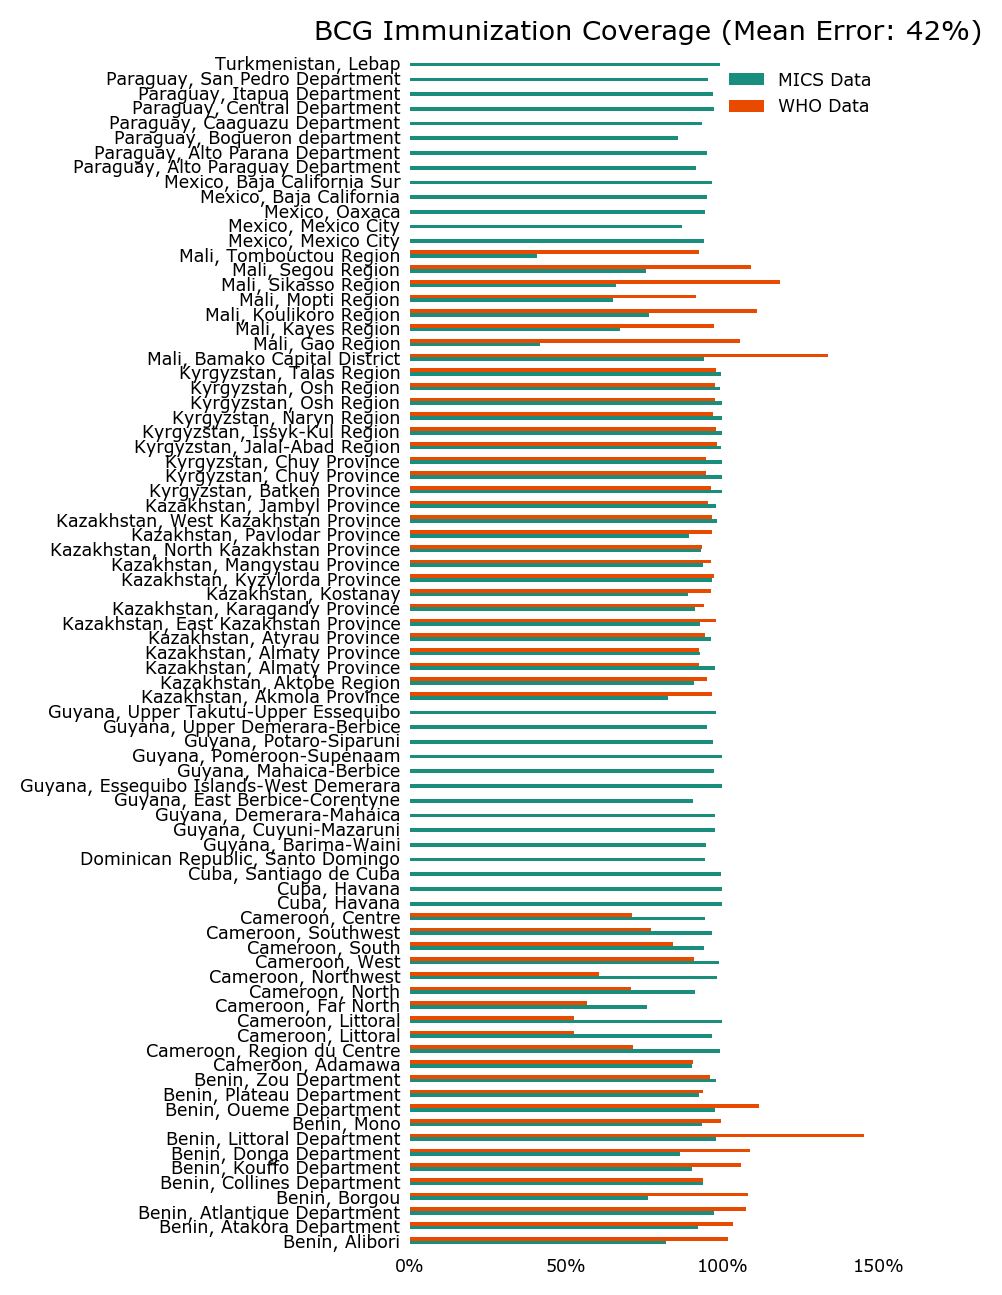

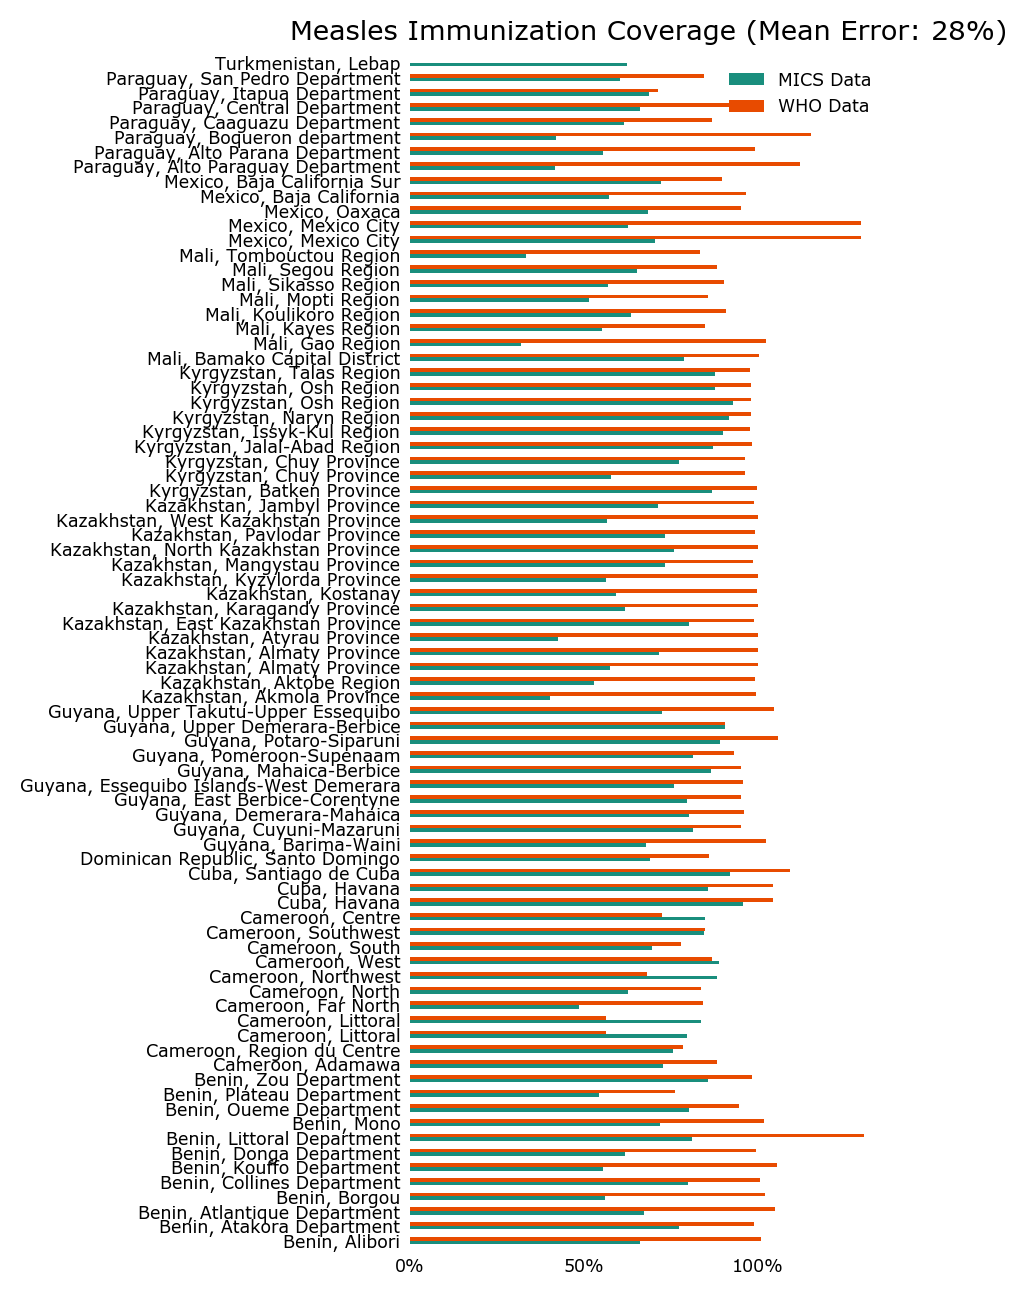

In [51]:
plot_together = [
    ('DTP', 'mics_DTP_any_dose', "DTP Immunization Coverage"),
    ('BCG', 'mics_BCG_any_dose', "BCG Immunization Coverage"),
    ('MCV', 'mics_Measles_any_dose', "Measles Immunization Coverage"),
]


for who_prefix, mics_prefix, title in plot_together:
    to_plot = pd.DataFrame({
        'WHO Data': who_and_mics_by_admin1[[c for c in who_and_mics_by_admin1.columns if c.startswith(who_prefix)]].fillna(0).max(axis=1).values,
        'MICS Data': who_and_mics_by_admin1[mics_prefix].values,
        },
        index = (who_and_mics_by_admin1.country + ", " + who_and_mics_by_admin1.google_admin_1).values
    )
    
    with styled_fig_ax(size='custom', font_size=8, x_formatter=pct_func_formatter(), zero_lines=False,
                       other_rc_params={'figure.figsize': (3, 6.5)}) as ax:
        to_plot.plot.barh(ax=ax)
        av_err = to_plot.diff(axis=1).abs().mean().values[1]
        ax.set_title(title + " (Mean Error: {:.0f}%)".format(av_err*100))


In [52]:
who_df[((who_df['Country Name'] == 'Paraguay') & 
        (who_df['Vaccine Type'] == 'BCG'))]

,Iso Code,Country Name,WHO Region,Year,Vaccine Type,Admin1,Admin2,DenomType,Denominator,Numerator,Coverage,recalc_numerator,available_admin,normalized_country,indicator,group,vaccine,timing,reported


In [53]:
# upsampled = upsample_dhs(rwa_dhs)

# upsampled.sdistrict = clean_uga_districts(upsampled.sdistrict)
# who_rwa.Admin2 = clean_who_rwa_names(who_rwa.Admin2)



# vax_rates = calculate_rate(upsampled, vaxes)
# unsampled_vax_rates = calculate_rate(rwa_dhs, vaxes)

# district_sums = calculate_district_sums(upsampled, rwa_dhs, vax_rates, unsampled_vax_rates)

# coverage_by_Admin2 = get_admin2_coverage(who_rwa)
# bar_plot_who_dhs(coverage_by_Admin2, district_sums)
violin_plot_who_dhs(coverage_by_Admin2,
                    district_sums,
                    "Rwanda Distribution of Vaccine Coverage Aross Regions",
                    ylim=(0, 2.0))


NameError: name 'violin_plot_who_dhs' is not defined

In [ ]:
# from unidecode import unidecode

# def clean_geo_names(x):
#     x = unidecode(x.strip().upper())
#     x = x.replace("-", " ")
#     return x

In [ ]:
# yr=2014
# df=coverage_dfs[0]

# subset_who = coverage_by_Admin1[coverage_by_Admin1['Country Name'].isin(df.country.unique())]
# subset_who['Admin1'] = subset_who['Admin1'].apply(clean_geo_names)


# subset_who.columns = [f"{c}_{yr}" for c in subset_who.columns]
# subset_who.rename(columns={f'Country Name_{yr}': 'country', f'Admin1_{yr}': 'HH7'}, inplace=True)


# df.HH7 = df.HH7.apply(clean_geo_names)

# shared_regions = np.intersect1d(df.HH7.unique(), subset_who.HH7.unique())

# df = df.sort_values(['country', 'HH7'])[df.HH7.isin(shared_regions)]
# subset_who = subset_who[subset_who.HH7.isin(shared_regions)].sort_values(['country', 'HH7'])

In [ ]:
df

In [ ]:
subset_who